# Model Evaluation
Use this notebook to evaluate your models against MCTS and to understand when your model is confident vs. not confident.

In [1]:
# Input: change the file names here if you want to evaluate a different model
cnn_filename = 'best_connect4_cnn.h5'
transformer_filename = None
data_filename = 'data/6-7-2shape_cleaned.pkl'

In [2]:
# Check environment being used!!
import sys
print(sys.version) # should be 3.9.19 to match Femke's

# either use virtual environment or use requirements.txt versions by running the line below
# your python version still might not be right though, so using the virtual environment is the safest.
# Also, if you use a package that isn't installed in the virtual environment, then you can take note of it
# and we can add it
# Can also use this to reset packages to the proper versions within requirements.txt in case you changed anything

# !pip install -r requirements.txt

3.9.19 (main, May  6 2024, 14:39:30) 
[Clang 14.0.6 ]


In [3]:
# Load libraries

# Data
import numpy as np
import pandas as pd
import pickle
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output # to clear plot output

# Models
import tensorflow as tf
from tensorflow.keras.models import load_model

# System
import time # stall between moves

In [4]:
#Load dataset for analysis
# df = pd.read_pickle(data_filename)
# x = df['x']
# y = df['y']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 22)
# X_train = np.stack(X_train)
# X_test = np.stack(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

## Functions for Play

In [5]:
def update_board(board_temp,color,column):
    """
    Update the game board by placing a checker in the specified column.

    This function takes the current board status, the player's checker color,
    and the column in which they want to place the checker, then updates the board accordingly.
    If the column is full, an error will be returned.

    Args:
        board_temp (numpy.ndarray): A 2x6x7 representation of the game board.
            The first layer corresponds to one player, and the second layer to the other.
            Values are 0 (empty) or 1 (occupied).
        color (str): The color of the checker, either 'red' or 'yellow'.
            'red' corresponds to the first layer (index 0), and 'yellow' to the second layer (index 1).
        column (int): The column (0 through 6) where the checker should be placed.
            If the column is full, the board remains unchanged.

    Returns:
        numpy.ndarray: The updated board after placing the checker.
        If the column is full, an error will be returned.

    Notes:
        - The board is copied before making modifications, ensuring the original input remains unchanged.
        - Maybe we should ask the player for another move if they select something invalid.
    """
    board = board_temp.copy()
    ncol = board.shape[1]
    nrow = board.shape[0]

    # this seems silly, but actually faster to run than using sum because of overhead!
    # colsum = sum(board[0, row, column] + board[1, row, column] for row in range(nrow))
    colsum = board[0,column,0]+board[1,column,0]+ board[2,column,0] + board[3,column,0] + board[4,column,0] + board[5,column,0] + board[0,column,1] + board[1,column,1] + board[2,column,1] + board[3,column,1] + board[4, column,1] + board[5, column,1]
    # no need to do abs() now because both boards are filled in with either 0s or 1s (no more -1s now that we have one "board" per opponent)

    # Check if the selected column is full (might slow down runtime, only necessary for human play)
    if colsum == nrow:
        raise ValueError(f"Column {column} is full. Please select a different column.")

    row = int(5-colsum) # returns index 0 - 5
    if row > -0.5:
      # i.e. as long as we have a slot available
        if color == 'red':
            board[row,column,0] = 1
        else:
            board[row,column,1] = 1
    return board

In [6]:
def check_for_win(board,col):
    """
    Check for a winning condition in the game after a move in the specified column.

    This function evaluates the board to determine if the most recent move in the specified
    column resulted in a win. It checks for four consecutive checkers of the same color
    in vertical, horizontal, and diagonal directions.

    Args:
        board (numpy.ndarray): A 2x6x7 representation of the game board.
            The first layer corresponds to the 'red' player's pieces, and the second layer to 'yellow'.
            Each layer contains 0s (empty) or 1s (occupied).
        col (int): The column (0 through 6) where the move was made.

    Returns:
        str: A string indicating the result of the check:
            - 'v-red': Vertical win for the 'red' player.
            - 'v-yellow': Vertical win for the 'yellow' player.
            - 'h-red': Horizontal win for the 'red' player.
            - 'h-yellow': Horizontal win for the 'yellow' player.
            - 'd-red': Diagonal win for the 'red' player (bottom-left to top-right).
            - 'd-yellow': Diagonal win for the 'yellow' player (bottom-left to top-right).
            - 'nobody': No winning condition is detected.

    Notes:
        - Assumes that the move in the given column was valid (i.e., the column was not full).
        - The function checks for wins starting from the position of the most recent move.
        - Diagonal checks include both bottom-left-to-top-right and top-left-to-bottom-right directions.
    """
    nrow = 6
    ncol = 7
    # take advantage of knowing what column was last played in...need to check way fewer possibilities
    board = board[:,:,0] - board[:,:,1] # create same board as what Dan used (6x7 with +1 for 'red' and -1 for 'yellow')
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-red'
        elif vert == -4:
            return 'v-yellow'
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row+3<6 and col-3>=0:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-1 >= 0 and col+1 < 7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-2 >=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    return 'nobody'

In [7]:
def find_legal(board):
    board = board[:,:,0] + board[:,:,1]
    # Identify columns that aren't full
    legal = [i for i in range(7) if board[0,i] == 0]
    return legal

In [8]:
def look_for_win(board_,color):
    '''
    Use this so that our bot will play a winning move regardless of what move the model tells it to pick.
    Just in case our model misses an opportunity to win.
    '''
    board_ = board_.copy()
    legal = find_legal(board_)
    winner = -1
    for m in legal:
        bt = update_board(board_.copy(),color,m)
        wi = check_for_win(bt,m)
        if wi[2:] == color:
          # only checking the last part of the string that check_for_win returns; e.g. 'd-yellow' becomes 'yellow'
            winner = m
            break
    return winner

In [9]:
def find_all_nonlosers(board,color):
    '''
    If there is not a winning move for our bot, make sure they block an opponent if they will
    win on their next turn. If the opponent has two places they could win, then our bot will pick
    one place to block.
    '''
    if color == 'red':
        opp = 'yellow'
    else:
        opp = 'red'
    legal = find_legal(board)
    poss_boards = [update_board(board,color,l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    # we do the second find_legal() to check that we aren't accidentally giving our opponent a win. just because the current team plays a legal move,
    # still leaves the possibility that the opponent's next move will win them the game
    allowed = []
    for i in range(len(legal)):
        wins = [j for j in poss_legal[i] if check_for_win(update_board(poss_boards[i],opp,j),j) != 'nobody']
        # alternative way to check if check_for_win return any winners; add the column when check_for_win returns anything but 'nobody'
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

In [10]:
def plot_connect4(board, ax=None):
    """
    Plots a Connect 4 board using Matplotlib.

    Parameters:
        board (3D numpy array): A 2x6x7 matrix representing the board state.
                                Player 1 is the first 6x7 board and Player 2 is the 2nd 6x7 board.
                                0 for empty, 1 for occupied board space.
        ax (matplotlib.axes): Matplotlib Axes object to plot on (optional).
    """
    rows, cols = board[:,:,0].shape
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    # Plot grid
    for row in range(rows):
        for col in range(cols):
            color = "white"  # Default empty color
            if board[row, col,0] == 1:
                color = "red"  # Player 1's pieces
            elif board[row, col,1] == 1:
                color = "yellow"  # Player 2's pieces

            # Draw a circle for each slot
            circle = plt.Circle((col + 0.5, rows - row - 0.5), 0.4, color=color, ec="black", lw=1)
            ax.add_patch(circle)

    # Configure axis
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(np.arange(cols) + 0.5, labels=np.arange(1, cols + 1))
    ax.set_yticks(np.arange(rows) + 0.5, labels=np.arange(rows, 0, -1))
    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_facecolor("blue")  # Board background color
    ax.tick_params(left=False, bottom=False, labelsize=12)

    plt.show()

The functions below are used for MCTS. We don't need to host this on AWS. Just using to test the quality of our model.

In [11]:
def back_prop(winner,path,color0,md):
    '''
    Updates the tree being developed by Monte Carlo tree search with the results of one simulated game.
    Moves that lead to the current player winning will be played more in the future based on this updated tree,
    whereas moves that lead to the current player losing will be played less in the future.
    '''
  # goal is count the number of times a node in the tree is visited (md[board_temp][0]) as well as keep track of the "reward"
  # for the initiating player at each node

    for i in range(len(path)):
        board_temp = path[i]

        md[board_temp][0]+=1
        # md is a dictionary

        if winner[2]==color0[0]:
          # in this scenario, the initiating player (color0) won the game
            if i % 2 == 1: # opponent's move
            # if an opponent's move led to color0 winning, that increases color0's reward at that node
                md[board_temp][1] += 1

            else:
                md[board_temp][1] -= 1
            # decrease the reward to reflect a missed opportunity; color0 did not win on its turn. it won down the road, but this helps us find the true
            # optimal strategy rather than strategies that will ~eventually~ lead to a win

        elif winner[2]=='e': # tie
            # md[board_temp][1] += 0
            pass
        else:
            if i % 2 == 1: # opponent's move
                md[board_temp][1] -= 1
            else:
                md[board_temp][1] += 1
                # i'm not sure why this last line is like this... isn't this rewarding the initiating player for the opponent winning after their move?

In [12]:
def rollout(board,next_player):
    '''
    Simulates games within MCTS to select the best move.
    '''
    winner = 'nobody'
    player = next_player
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            winner = 'tie'
            return winner
        move = random.choice(legal)
        board = update_board(board,player,move)
        winner = check_for_win(board,move)

        if player == 'red':
            player = 'yellow'
        else:
            player = 'red'
    return winner

In [13]:
def mcts(board_temp,color0,nsteps):
    # nsteps is a parameter that determines the skill (and slowness) of the player
    # bigger values of nsteps means the player is better, but also slower to figure out a move.
    board = board_temp.copy()
    ##############################################
    winColumn = look_for_win(board,color0) # check to find a winning column
    if winColumn > -0.5:
        return winColumn # if there is one - play that!
    legal0 = find_all_nonlosers(board,color0) # find all moves that won't immediately lead to your opponent winning
    if len(legal0) == 0: # if you can't block your opponent - just find the 'best' losing move
        legal0 = find_legal(board)
    ##############################################
    # the code above, in between the hash rows, is not part of traditional MCTS
    # but it makes it better and faster - so I included it!
    # MCTS occasionally makes stupid mistakes
    # like not dropping the checker on a winning column, or not blocking an obvious opponent win
    # this avoids a little bit of that stupidity!
    # we could also add this logic to the rest of the MCTS and rollout functions - I just haven't done that yet...
    # feel free to experiment!
    mcts_dict = {tuple(board.ravel()):[0,0]}
    for ijk in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        # play until someone wins or there is a tie
        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner,path,color0,mcts_dict)
                break
            board_list = []
            for col in legal:
                board_list.append(tuple(update_board(board_mcts,color,col).ravel()))
            for bl in board_list:
                if bl not in mcts_dict.keys():
                    mcts_dict[bl] = [0,0]
            ucb1 = np.zeros(len(legal))
            for i in range(len(legal)):
                num_denom = mcts_dict[board_list[i]]
                if num_denom[0] == 0:
                    ucb1[i] = 10*nsteps
                else:
                    ucb1[i] = num_denom[1]/num_denom[0] + 2*np.sqrt(np.log(mcts_dict[path[-1]][0])/mcts_dict[board_list[i]][0])
            chosen = np.argmax(ucb1)

            board_mcts = update_board(board_mcts,color,legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            winner = check_for_win(board_mcts,legal[chosen])
            if winner[2]==color[0]:
                back_prop(winner,path,color0,mcts_dict)
                break
            if color == 'red':
                color = 'yellow'
            else:
                color = 'red'
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner = rollout(board_mcts,color)
                back_prop(winner,path,color0,mcts_dict)
                break

    maxval = -np.inf
    best_col = -1
    for col in legal0:
        board_temp = tuple(update_board(board,color0,col).ravel())
        num_denom = mcts_dict[board_temp]
        if num_denom[0] == 0:
            compare = -np.inf
        else:
            compare = num_denom[1] / num_denom[0]
        if compare > maxval:
            maxval = compare
            best_col = col
    return (best_col)

## CNN

### Example Boards

In [55]:
# load the best model
custom_objects = {
    'softmax_v2': tf.keras.activations.softmax
}
model = load_model(cnn_filename, custom_objects=custom_objects)

In [68]:
y_hat = model.predict(X)
y_hat_df = pd.DataFrame(y_hat, columns=[f"prob_move_{i}" for i in range(7)])
y_hat_df['predicted_move'] = np.argmax(y_hat, axis=1)
y_hat_df['predicted_move_probability'] = np.max(y_hat, axis=1)
y_hat_df['actual_move'] = df['y']
y_hat_df["actual_move_probability"] = y_hat[np.arange(len(y_hat)), df['y'].values]
y_hat_df['x'] = df['x']

display(y_hat_df.head())

14168/14168 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step


,prob_move_0,prob_move_1,prob_move_2,prob_move_3,prob_move_4,prob_move_5,prob_move_6,predicted_move,predicted_move_probability,actual_move,actual_move_probability,x
0,4.544423e-04,0.011306,0.007463,0.069775,0.784532,1.226804e-01,3.789850e-03,4,0.784532,4.0,0.784532,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ..."
1,2.864000e-07,0.000002,0.000085,0.000444,0.999467,1.866365e-07,5.621092e-07,4,0.999467,4.0,0.999467,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ..."
2,4.811836e-04,0.020900,0.047846,0.049808,0.000345,8.619421e-01,1.867792e-02,5,0.861942,5.0,0.861942,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ..."
3,3.929993e-03,0.030755,0.268345,0.682087,0.000160,1.339884e-02,1.325108e-03,3,0.682087,3.0,0.682087,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ..."
4,4.334913e-03,0.061093,0.017782,0.026769,0.002082,1.007289e-01,7.872102e-01,6,0.787210,6.0,0.787210,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ..."


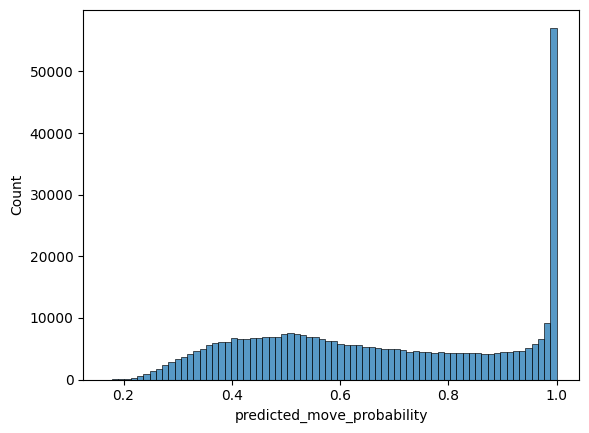

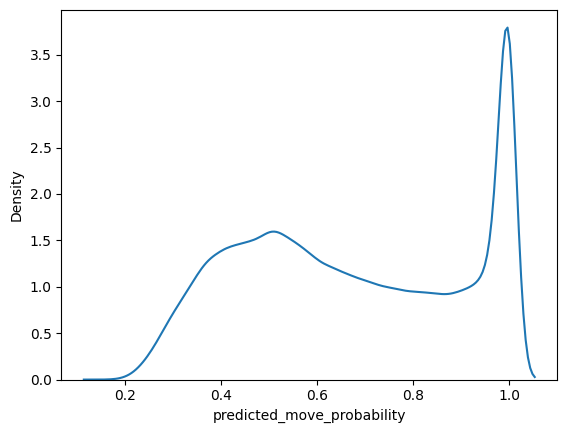

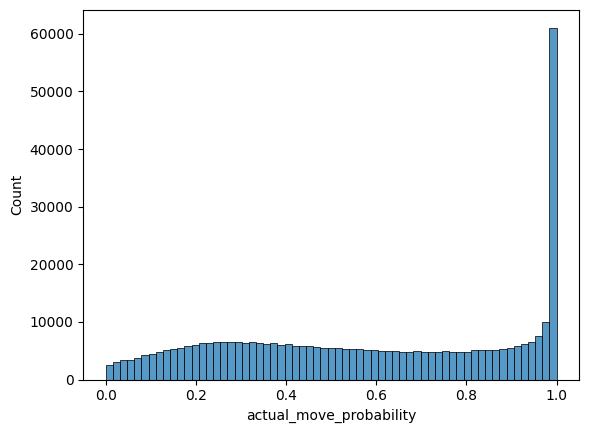

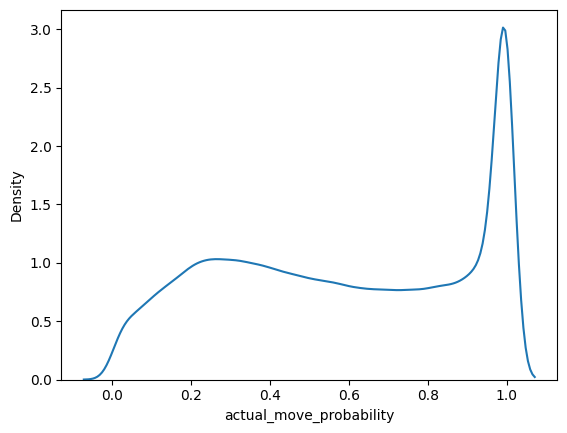

Most confident misclassification:


,prob_move_0,prob_move_1,prob_move_2,prob_move_3,prob_move_4,prob_move_5,prob_move_6,predicted_move,predicted_move_probability,actual_move,actual_move_probability,x
117746,1.217912e-11,2.559927e-13,1.0,4.972638e-15,2.443875e-12,1.475767e-10,4.704012e-12,2,1.0,4.0,1.0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ..."


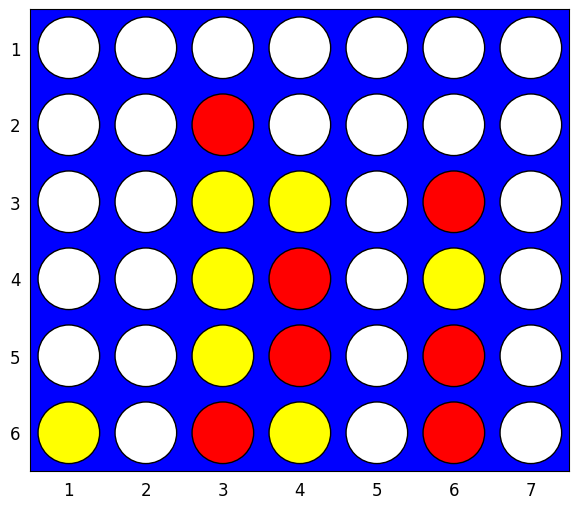

In [70]:
# boards not classified well and confident
confident_misclassifications = y_hat_df[
    y_hat_df['predicted_move']!=y_hat_df['actual_move']
    ].sort_values(by='predicted_move_probability', ascending=False)

# distribution of predicted move probabilities
sns.histplot(x=confident_misclassifications['predicted_move_probability'])
plt.show()
sns.kdeplot(x=confident_misclassifications['predicted_move_probability'])
plt.show()

# distribution of actual move probabilities
sns.histplot(x=confident_misclassifications['actual_move_probability'])
plt.show()
sns.kdeplot(x=confident_misclassifications['actual_move_probability'])
plt.show()

# plot the most confident board and compare what the predicted and actual move was
most_confident_misclassification = confident_misclassifications.head(1)
print('Most confident misclassification:')
display(most_confident_misclassification)
plot_connect4(most_confident_misclassification['x'].iloc[0])

Least confident misclassification:


,prob_move_0,prob_move_1,prob_move_2,prob_move_3,prob_move_4,prob_move_5,prob_move_6,predicted_move,predicted_move_probability,actual_move,actual_move_probability,x
154646,0.144475,0.161686,0.146848,0.137334,0.095291,0.147366,0.167,6,0.167,4.0,0.144475,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ..."


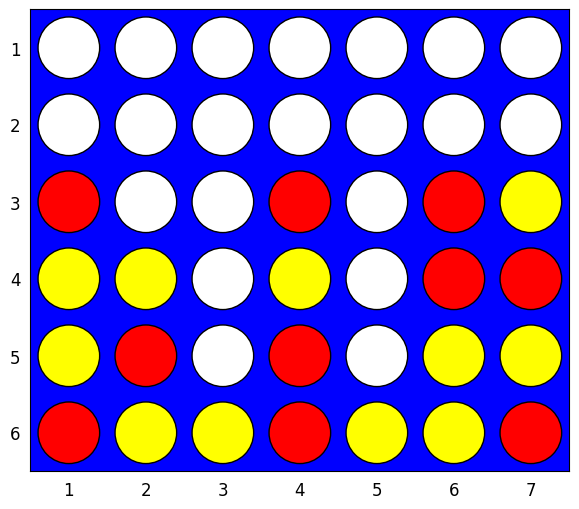

In [71]:
# boards not classified well and not confident
unconfident_misclassifications = y_hat_df[
    y_hat_df['predicted_move']!=y_hat_df['actual_move']
    ].sort_values(by='predicted_move_probability', ascending=True)

# plot the least confident board and compare what the predicted and actual move was
least_confident_misclassification = unconfident_misclassifications.head(1)
print('Least confident misclassification:')
display(least_confident_misclassification)
plot_connect4(least_confident_misclassification['x'].iloc[0])

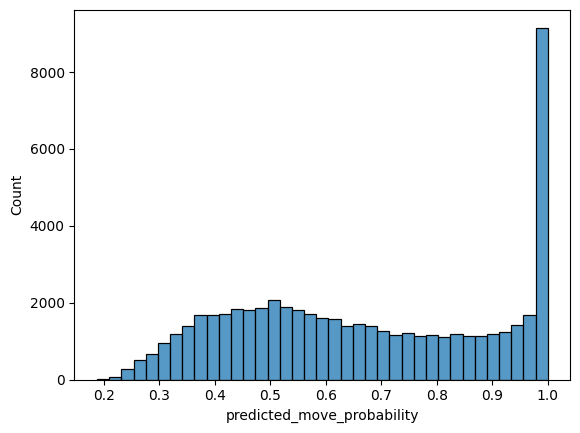

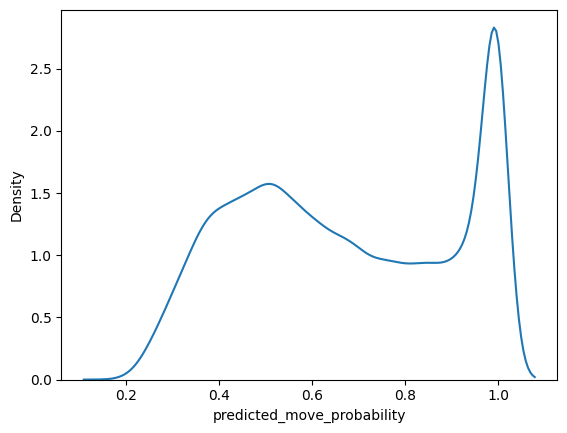

Most confident correct classification:


,prob_move_0,prob_move_1,prob_move_2,prob_move_3,prob_move_4,prob_move_5,prob_move_6,predicted_move,predicted_move_probability,actual_move,actual_move_probability,x
32956,2.456656e-09,2.008899e-10,9.295412e-11,1.299107e-10,1.0,3.069182e-10,1.290297e-09,4,1.0,4.0,1.0,"[[[1, 0], [0, 0], [0, 1], [0, 1], [0, 0], [0, ..."


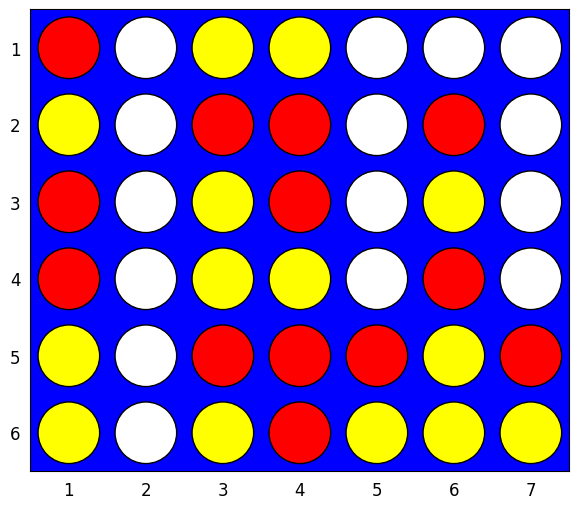

In [73]:
# boards classified well and confident
confident_correct_classifications = y_hat_df[
    y_hat_df['predicted_move']==y_hat_df['actual_move']
    ].sort_values(by='predicted_move_probability', ascending=False)

# distribution of predicted move probabilities
sns.histplot(x=confident_correct_classifications['predicted_move_probability'])
plt.show()
sns.kdeplot(x=confident_correct_classifications['predicted_move_probability'])
plt.show()
# don't need to plot actual move probabilities since they're the same here

# plot the least confident board and compare what the predicted and actual move was
most_confident_correct_classification = confident_correct_classifications.head(1)
print('Most confident correct classification:')
display(most_confident_correct_classification)
plot_connect4(most_confident_correct_classification['x'].iloc[0])

### Vs MCTS

In [16]:
# Load model to use
custom_objects = {
    'softmax_v2': tf.keras.activations.softmax
} # Because I had an issue loading the model
model = load_model(cnn_filename, custom_objects=custom_objects)


MCTS_levels = [100, 500, 2000, 5000]
colors = ['red', 'yellow']
games = 100
color_win_rates = {}
for bot_color in colors:
    win_rates = {}
    for MCTS_level in MCTS_levels:
        wins = 0
        for _ in range(games): # simulate 100 games for each level
            # Set up new game
            winner = 'nobody'
            board = np.zeros((6,7,2))
            player = 'red'
            
            # Determine which color each player is (red goes first)
            bot_player = bot_color
            if bot_color == 'red':
                MCTS_player = 'yellow'
            else:
                MCTS_player = 'red'
            
            # Begin game
            while winner == 'nobody':
                # Check for legal moves, else return 'tie'
                legal = find_legal(board)
                if len(legal) == 0:
                    winner = 'tie'
                    break
                
                if player == MCTS_player:
                    move = mcts(board, player, MCTS_level)
                    board = update_board(board,player,move)
            
                else:
                    # If bot is yellow, flip board for accurate predictions
                    if bot_player == 'yellow':
                        move = look_for_win(board,bot_player)
                        # Ignore model predictions and select winning move if there is one
                        if move > -0.5:
                            board = update_board(board,bot_player,move)
                        # Ensure you block a win on the next turn, even if model doesn't select that move
                        else:
                            nonlosing_moves = find_all_nonlosers(board,bot_player) # only play nonlosing moves
                            if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
                                temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
                                model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
                                legal_moves = find_legal(board)
                                bot_moves = model.predict(model_input, verbose=0)[0][legal_moves] # just get the highest probability move
                                pick_of_legal = np.argmax(bot_moves)
                                move = legal_moves[pick_of_legal]
                                board = update_board(board,bot_player,move)
                            else: # if you can block or don't need to block
                                temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
                                model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
                                bot_moves = model.predict(model_input, verbose=0)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
                                pick_of_nonlosing = np.argmax(bot_moves)
                                move = nonlosing_moves[pick_of_nonlosing]
                                board = update_board(board,bot_player,move)
                    else:
                        move = look_for_win(board,bot_player)
                        # ignore model predictions and select winning move if there is one
                        if move > -0.5:
                            board = update_board(board,bot_player,move)
                        # Ensure you block a win on the next turn, even if model doesn't select that move
                        else:
                            model_input = np.expand_dims(board, axis=0) # need to include an extra dimension for sample size = 1
                            nonlosing_moves = find_all_nonlosers(board, bot_player)
                            if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
                                legal_moves = find_legal(board)
                                bot_moves = model.predict(model_input, verbose=0)[0][legal_moves]
                                pick_of_legal = np.argmax(bot_moves)
                                move = legal_moves[pick_of_legal]
                                board = update_board(board,bot_player,move)
                            else: # if you can block or don't need to block
                                bot_moves = model.predict(model_input, verbose=0)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
                                pick_of_nonlosing = np.argmax(bot_moves)
                                move = nonlosing_moves[pick_of_nonlosing]
                                board = update_board(board,bot_player,move) 
                # Check for a win after either player plays
                winner = check_for_win(board,move)
            
                # Switch players and go onto the next turn if no one has won
                if player == 'red':
                    player = 'yellow'
                else:
                    player = 'red'
            if winner[2] == bot_color[0]:
                wins+=1
        win_rate = wins/games
        print(f'{bot_color} model win rate vs. level {MCTS_level}: {win_rate}')
        win_rates[MCTS_level] = win_rate
    color_win_rates[bot_color] = win_rates

red model win rate vs. level 100: 0.89
red model win rate vs. level 500: 0.63
red model win rate vs. level 2000: 0.35
red model win rate vs. level 5000: 0.16
yellow model win rate vs. level 100: 0.22
yellow model win rate vs. level 500: 0.08
yellow model win rate vs. level 2000: 0.05
yellow model win rate vs. level 5000: 0.02


In [17]:
color_win_rates

{'red': {100: 0.89, 500: 0.63, 2000: 0.35, 5000: 0.16},
 'yellow': {100: 0.22, 500: 0.08, 2000: 0.05, 5000: 0.02}}

## Transformer

In [ ]:
# Load model to use
# Check how to load transformer
# custom_objects = {
#     'softmax_v2': tf.keras.activations.softmax
# } # Because I had an issue loading the model
model = load_model(transformer_filename, custom_objects=custom_objects)


MCTS_levels = [100, 500, 2000, 5000]
colors = ['red', 'yellow']
games = 100
color_win_rates = {}
for bot_color in colors:
    win_rates = {}
    for MCTS_level in MCTS_levels:
        wins = 0
        for _ in range(games): # simulate 100 games for each level
            # Set up new game
            winner = 'nobody'
            board = np.zeros((6,7,2))
            player = 'red'
            
            # Determine which color each player is (red goes first)
            bot_player = bot_color
            if bot_color == 'red':
                MCTS_player = 'yellow'
            else:
                MCTS_player = 'red'
            
            # Begin game
            while winner == 'nobody':
                # Check for legal moves, else return 'tie'
                legal = find_legal(board)
                if len(legal) == 0:
                    winner = 'tie'
                    break
                
                if player == MCTS_player:
                    move = mcts(board, player, MCTS_level)
                    board = update_board(board,player,move)
            
                else:
                    # If bot is yellow, flip board for accurate predictions
                    if bot_player == 'yellow':
                        move = look_for_win(board,bot_player)
                        # Ignore model predictions and select winning move if there is one
                        if move > -0.5:
                            board = update_board(board,bot_player,move)
                        # Ensure you block a win on the next turn, even if model doesn't select that move
                        else:
                            nonlosing_moves = find_all_nonlosers(board,bot_player) # only play nonlosing moves
                            if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
                                temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
                                model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
                                legal_moves = find_legal(board)
                                bot_moves = model.predict(model_input, verbose=0)[0][legal_moves] # just get the highest probability move
                                pick_of_legal = np.argmax(bot_moves)
                                move = legal_moves[pick_of_legal]
                                board = update_board(board,bot_player,move)
                            else: # if you can block or don't need to block
                                temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
                                model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
                                bot_moves = model.predict(model_input, verbose=0)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
                                pick_of_nonlosing = np.argmax(bot_moves)
                                move = nonlosing_moves[pick_of_nonlosing]
                                board = update_board(board,bot_player,move)
                    else:
                        move = look_for_win(board,bot_player)
                        # ignore model predictions and select winning move if there is one
                        if move > -0.5:
                            board = update_board(board,bot_player,move)
                        # Ensure you block a win on the next turn, even if model doesn't select that move
                        else:
                            model_input = np.expand_dims(board, axis=0) # need to include an extra dimension for sample size = 1
                            nonlosing_moves = find_all_nonlosers(board, bot_player)
                            if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
                                legal_moves = find_legal(board)
                                bot_moves = model.predict(model_input, verbose=0)[0][legal_moves]
                                pick_of_legal = np.argmax(bot_moves)
                                move = legal_moves[pick_of_legal]
                                board = update_board(board,bot_player,move)
                            else: # if you can block or don't need to block
                                bot_moves = model.predict(model_input, verbose=0)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
                                pick_of_nonlosing = np.argmax(bot_moves)
                                move = nonlosing_moves[pick_of_nonlosing]
                                board = update_board(board,bot_player,move) 
                # Check for a win after either player plays
                winner = check_for_win(board,move)
            
                # Switch players and go onto the next turn if no one has won
                if player == 'red':
                    player = 'yellow'
                else:
                    player = 'red'
            if winner[2] == bot_color[0]:
                wins+=1
        win_rate = wins/games
        print(f'{bot_color} model win rate vs. level {MCTS_level}: {win_rate}')
        win_rates[MCTS_level] = win_rate
    color_win_rates[bot_color] = win_rates